# Import 

In [1]:
import pandas as pd
import numpy as np
import glob
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
from plotly import graph_objects as go

import sys
sys.path.append('/home/s312657018/TBrain/code')
import importlib
import dataset
importlib.reload(dataset)
from dataset import process_serial

- 7 個特徵:
    
    地點代號 LocationCode(1-17)
    
    間 DateTime(Y/M/D/hour/minute/second)
    
    風速 WindSpeed(m/s)、大氣壓力 Pressure(hPa)
    
    溫度 Temperature(°C)
    
    濕度 Humidity(%)
    
    亮度 Sunlight(Lux)
    
- 1 個標籤:

    太陽能板每分鐘平均發電量 Power(mW)


In [5]:
avgdata_paths = glob.glob('/home/s312657018/TBrain/示範程式/LSTM(比賽用)/ExampleTrainData(AVG)/AvgDATA_*.csv')
avgdata_dict = {}

for i in range(len(avgdata_paths)):
    df_num = avgdata_paths[i].split('.')[0][-2:]
    avgdata_dict[f'avgdata_{df_num}'] = pd.read_csv(avgdata_paths[i])

data = pd.concat([process_serial(df, 'Serial') for df in avgdata_dict.values()], ignore_index=True)
data.to_csv('/home/s312657018/TBrain/data-preprocess/AvgDATA.csv')

In [4]:
data

,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Datetime,Year,Month,Day,Hour,Minute,Station_ID,WindSpeed(m/s)_x_Sunlight(Lux),Temperature(°C)_x_Sunlight(Lux)
0,1.52,1018.29,31.07,39.43,61489.24,674.02,2024-03-03 13:00:00,2024,3,3,13,0,16,93463.6448,1.910471e+06
1,2.08,1018.17,29.39,41.34,52029.41,500.13,2024-03-03 13:10:00,2024,3,3,13,10,16,108221.1728,1.529144e+06
2,2.13,1018.06,26.81,46.64,35562.88,212.07,2024-03-03 13:20:00,2024,3,3,13,20,16,75748.9344,9.534408e+05
3,1.59,1017.93,26.60,47.47,33044.66,180.92,2024-03-03 13:30:00,2024,3,3,13,30,16,52541.0094,8.789880e+05
4,1.66,1017.82,25.88,49.25,28176.42,131.18,2024-03-03 13:40:00,2024,3,3,13,40,16,46772.8572,7.292057e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66055,0.00,1006.39,33.15,83.29,1380.42,0.76,2024-07-15 16:10:00,2024,7,15,16,10,11,0.0000,4.576092e+04
66056,0.00,1006.44,33.01,83.87,1355.25,0.68,2024-07-15 16:20:00,2024,7,15,16,20,11,0.0000,4.473680e+04
66057,0.00,1006.52,32.84,85.04,1379.58,0.72,2024-07-15 16:30:00,2024,7,15,16,30,11,0.0000,4.530541e+04
66058,0.00,1006.57,32.84,85.49,1337.00,0.68,2024-07-15 16:40:00,2024,7,15,16,40,11,0.0000,4.390708e+04


In [4]:
avgdata_dict['avgdata_01']['Power(mW)'].describe()

count    5700.000000
mean      396.818535
std       534.020010
min         0.020000
25%        19.665000
50%       102.530000
75%       654.825000
max      2001.440000
Name: Power(mW), dtype: float64

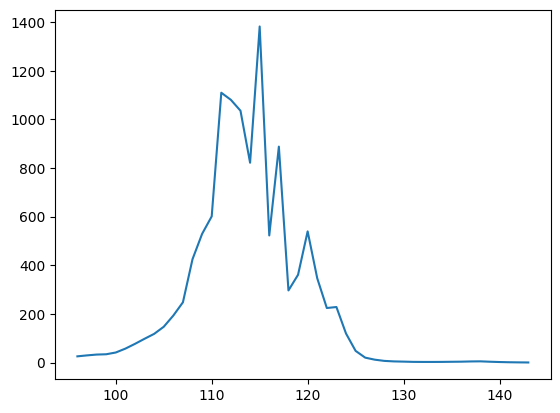

In [10]:
plt.plot(avgdata_dict['avgdata_01']['Power(mW)'][96:48*3])
# avgdata_dict['avgdata_01'][:48]

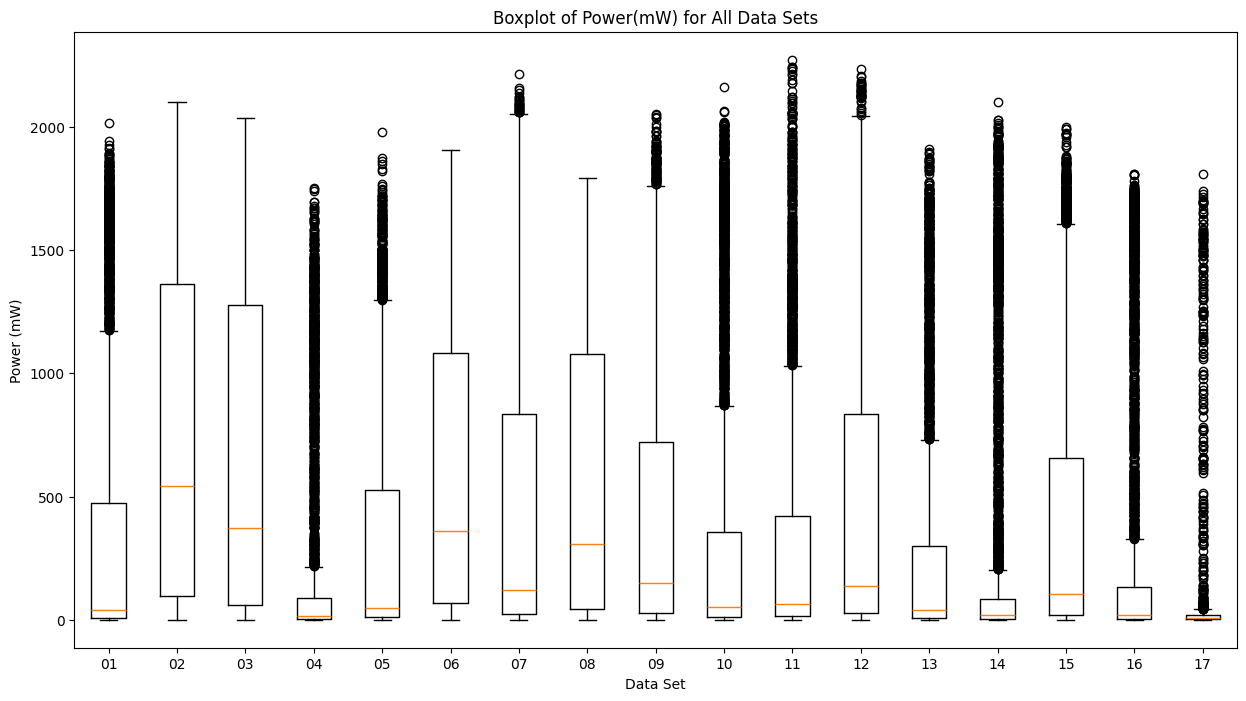

In [11]:
all_data = [df['Power(mW)'] for df in avgdata_dict.values()]

plt.figure(figsize=(15, 8))
plt.boxplot(all_data)

plt.xticks(ticks=range(1, len(all_data) + 1), labels=[f'{i:02d}' for i in range(1, len(all_data) + 1)])

plt.title('Boxplot of Power(mW) for All Data Sets')
plt.xlabel('Data Set')
plt.ylabel('Power (mW)')
plt.show()

In [27]:
features = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', 'Month', 'Hour', 'Datetime']

In [ ]:
avgdata1 = avgdata_dict['avgdata_01']
fig = sp.make_subplots(rows=2, cols=4, subplot_titles=[f'Power vs {col_name}' for col_name in features])

# 繪製每個特徵的散點圖
for i, col_name in enumerate(features):
    fig.add_trace(
        go.Scatter(x=avgdata1['Power(mW)'], y=avgdata1[col_name], mode='markers', name=col_name),
        row=i // 4 + 1, col=i % 4 + 1
    )

# 設定標籤
fig.update_layout(
    height=600,
    width=1200,
    title_text="Power vs Features",
    xaxis_title="Power (mW)",
    yaxis_title="Feature Value"
)

# 顯示圖形
fig.show()

#### Timestamp 之間的相關性確實很低（僅為 0.062），這表明 Timestamp 對 Power(mW) 的直接解釋能力較弱。這種情況在一些時間序列數據中是常見的，因為單純的時間戳（數字型連續時間）無法很好地捕捉到特定的周期性模式。
(可以對 hour, month 做週期性轉換捕捉時間趨勢，這部分還沒做)

In [ ]:
features.append('Power(mW)')
correlation_matrix = avgdata1[features].corr()
correlation_matrix

,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Month,Hour,Datetime,Power(mW)
WindSpeed(m/s),1.000000,0.026054,-0.042136,-0.150821,0.129700,-0.191496,-0.016236,-0.191721,0.138284
Pressure(hpa),0.026054,1.000000,-0.329756,0.057026,-0.080448,-0.423479,-0.089712,-0.439996,-0.072097
Temperature(°C),-0.042136,-0.329756,1.000000,-0.684137,0.716499,0.612706,-0.242895,0.630559,0.696873
Humidity(%),-0.150821,0.057026,-0.684137,1.000000,-0.700883,-0.101052,0.253219,-0.108512,-0.669588
Sunlight(Lux),0.129700,-0.080448,0.716499,-0.700883,1.000000,0.157587,-0.431974,0.166625,0.941407
Month,-0.191496,-0.423479,0.612706,-0.101052,0.157587,1.000000,-0.006155,0.986303,0.151678
Hour,-0.016236,-0.089712,-0.242895,0.253219,-0.431974,-0.006155,1.000000,-0.004842,-0.369933
Datetime,-0.191721,-0.439996,0.630559,-0.108512,0.166625,0.986303,-0.004842,1.000000,0.159386
Power(mW),0.138284,-0.072097,0.696873,-0.669588,0.941407,0.151678,-0.369933,0.159386,1.000000


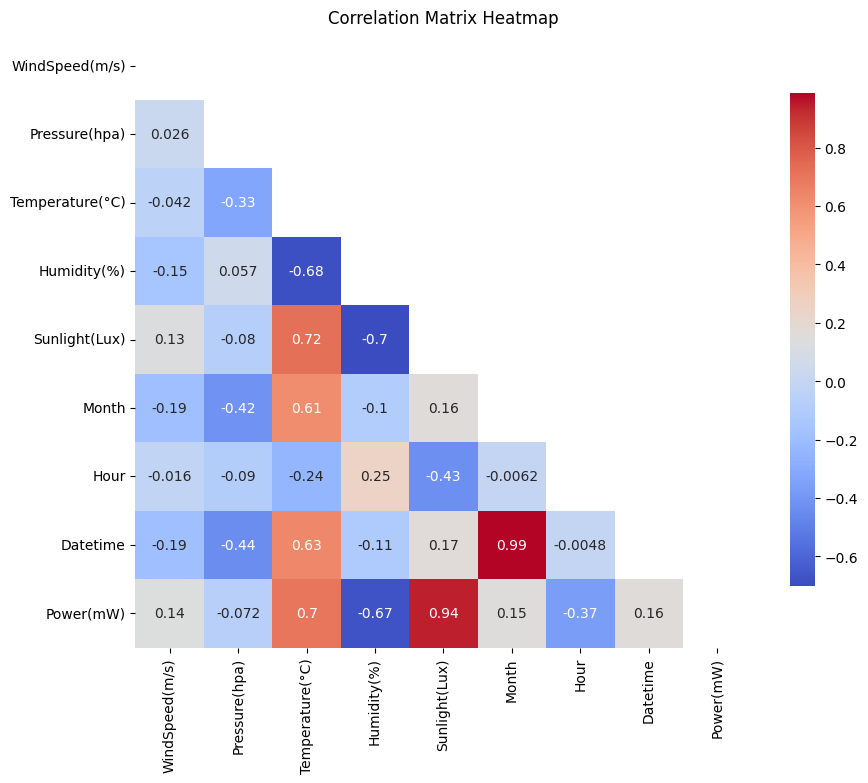

In [26]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 繪製熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap')
plt.show()

-------------
### 要做 ARIMA 再看下面的轉換

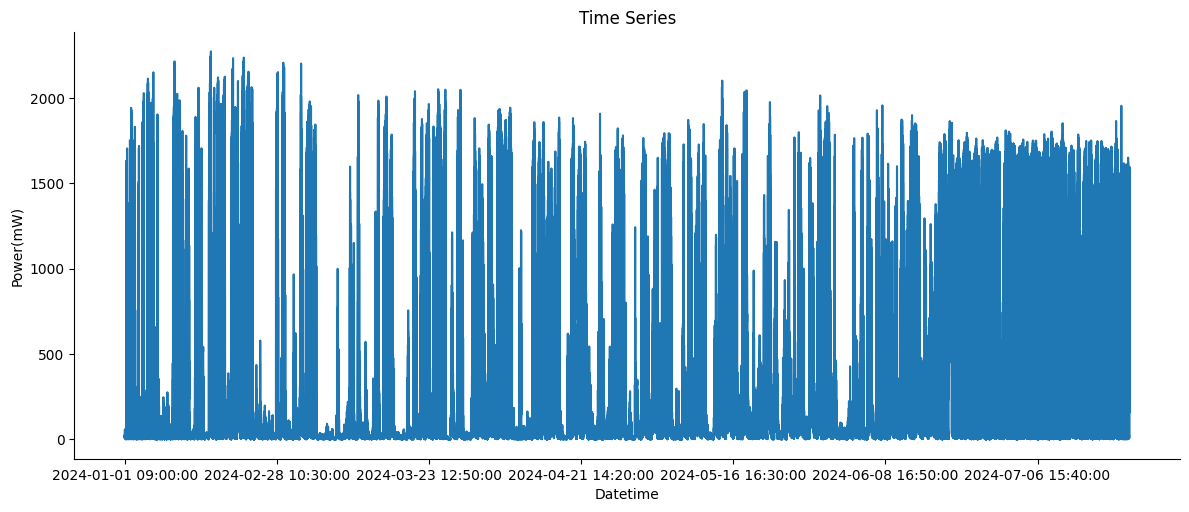

In [35]:
data = pd.read_csv('/home/s312657018/TBrain/data-preprocess/AvgDATA.csv')
df1=data.loc[:,['Datetime','Power(mW)']] 
df1.sort_values(by='Datetime', inplace=True)
df1.set_index('Datetime',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Power(mW)')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Time Series')
sns.despine(top=True)
plt.show()


#### 資料太多了看不出什麼毛線，先看一個月

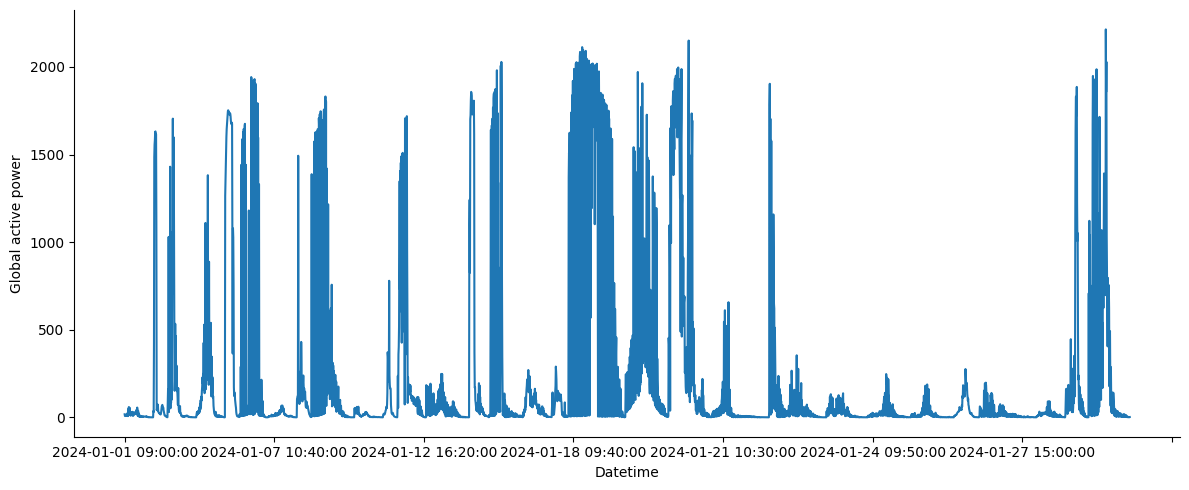

In [ ]:
df2=df1[(df1.index>='2024-01-01') & (df1.index<'2024-01-31')]
df2.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show()

,count,mean,std,min,25%,50%,75%,max
Power(mW),66060.0,367.109249,544.922115,0.0,10.35,56.36,552.0825,2272.62


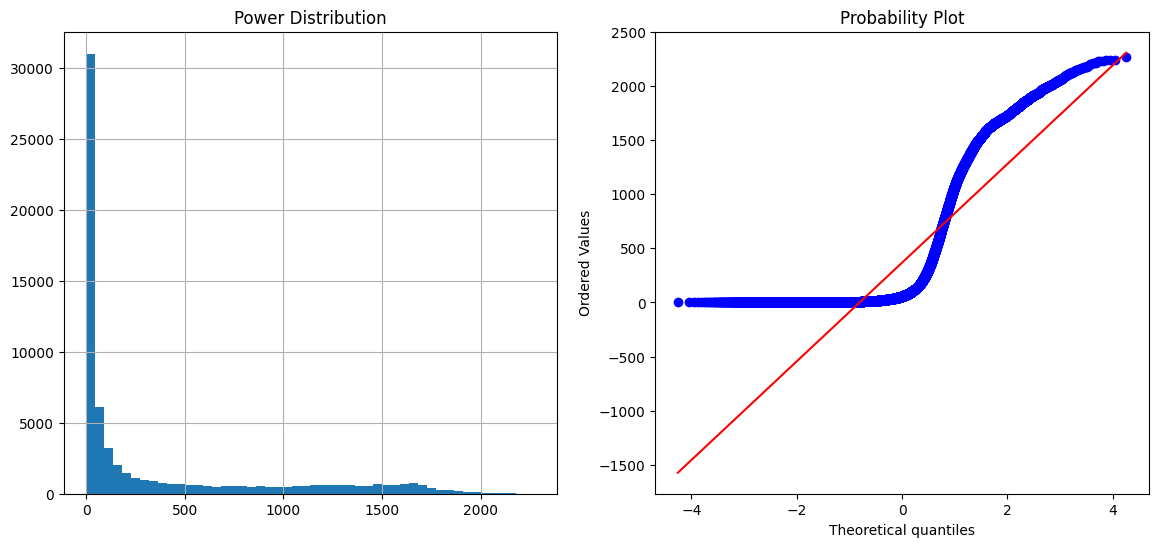

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
data['Power(mW)'].hist(bins=50)
plt.title('Power Distribution')

plt.subplot(1,2,2)
stats.probplot(data['Power(mW)'], plot=plt)
df1.describe().T

#### Power resampled over day, month, quarter and Hour.

Number of duplicate timestamps: 55818


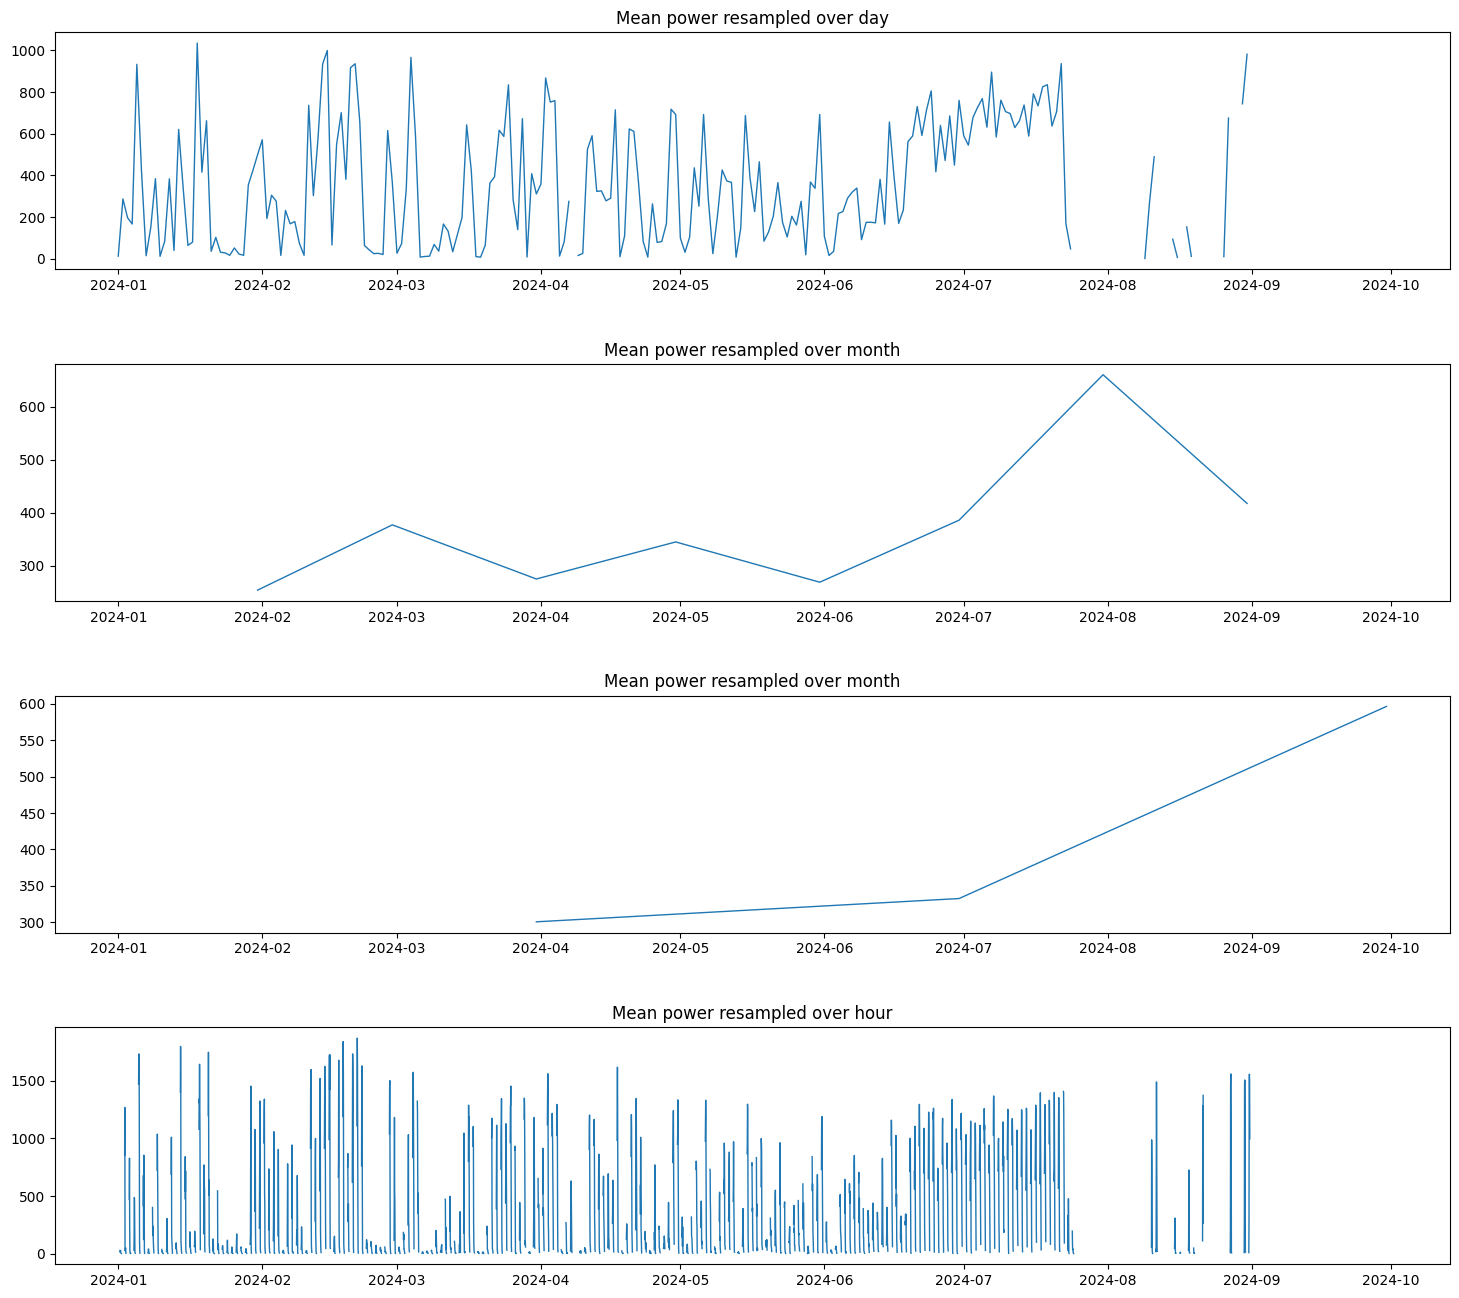

In [ ]:
duplicates = data.index.duplicated().sum()
print(f"Number of duplicate timestamps: {duplicates}")

if duplicates > 0:
    # 解決重複索引：這裡使用均值，可以根據需求調整為 'sum', 'first', 等
    data = data.groupby(data.index).mean()

# 繪圖
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=.4)

# 日重採樣
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(data['Power(mW)'].resample('D').mean(), linewidth=1)
ax1.set_title('Mean power resampled over day')
ax1.tick_params(axis='both', which='major')

# 月重採樣
ax2 = fig.add_subplot(4, 1, 2, sharex=ax1)
ax2.plot(data['Power(mW)'].resample('ME').mean(), linewidth=1)
ax2.set_title('Mean power resampled over month')
ax2.tick_params(axis='both', which='major')

# 季重採樣
ax3 = fig.add_subplot(4, 1, 3, sharex=ax1)
ax3.plot(data['Power(mW)'].resample('QE').mean(), linewidth=1)
ax3.set_title('Mean power resampled over month')
ax3.tick_params(axis='both', which='major')

# 時重採樣
ax4 = fig.add_subplot(4, 1, 4, sharex=ax1)
ax4.plot(data['Power(mW)'].resample('h').mean(), linewidth=1)
ax4.set_title('Mean power resampled over hour')
ax4.tick_params(axis='both', which='major')

plt.show()

### Dickey-Fuller Test to Ceck Stationarity
In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

#### Dickey-Fuller test
Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

參考網站： https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/LSTM%20Time%20Series%20Power%20Consumption.ipynb

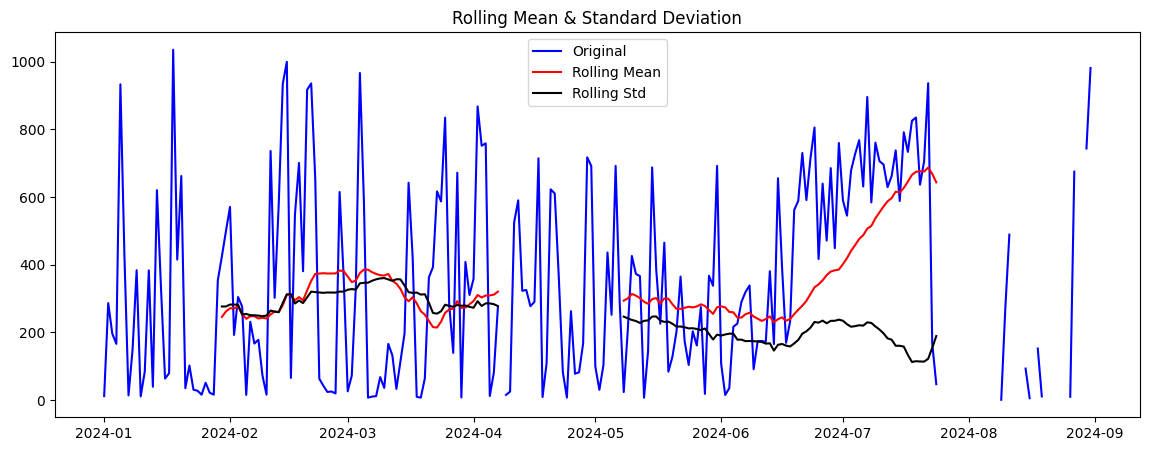

<Results of Dickey-Fuller Test>
Test Statistic                -9.064962e+00
p-value                        4.458289e-15
#Lags Used                     0.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


In [ ]:
# 重採樣日均值
df2 = data['Power(mW)'].resample('D').mean()

def test_stationarity(timeseries):
    # 計算滾動平均和滾動標準差
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    # 繪製原始數據、滾動平均和滾動標準差
    plt.figure(figsize=(14, 5))
    sns.despine(left=True)
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Dickey-Fuller Test 結果
    print('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

# 檢查 df2 是否平穩
test_stationarity(df2)


the data does not have a unit root and is stationary.

## 一階平滑化

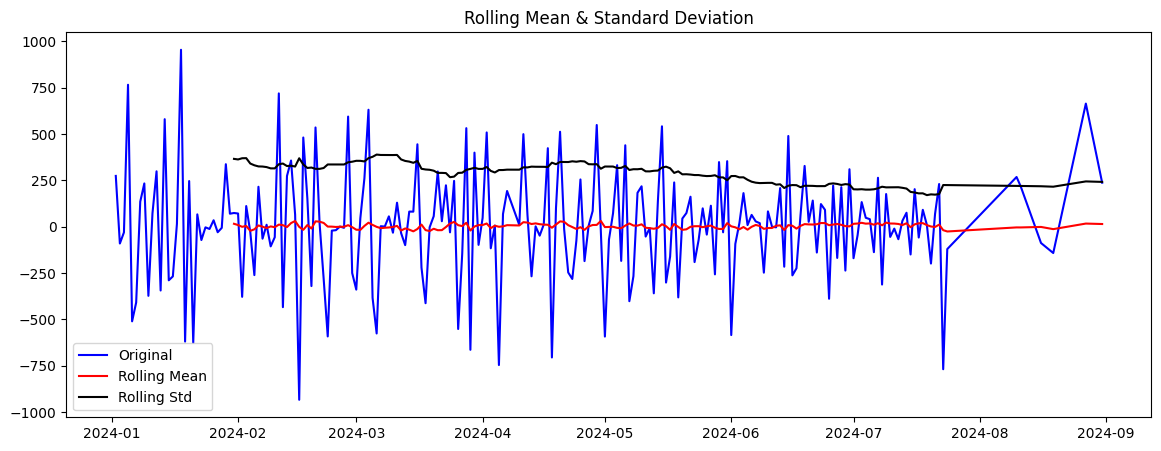

<Results of Dickey-Fuller Test>
Test Statistic                -7.390623e+00
p-value                        8.018803e-11
#Lags Used                     9.000000e+00
Number of Observations Used    1.990000e+02
Critical Value (1%)           -3.463645e+00
Critical Value (5%)           -2.876176e+00
Critical Value (10%)          -2.574572e+00
dtype: float64


In [53]:
data['Power(mW)_diff'] = data['Power(mW)'].diff()
df2_diff = df2.diff().dropna()

test_stationarity(df2_diff)

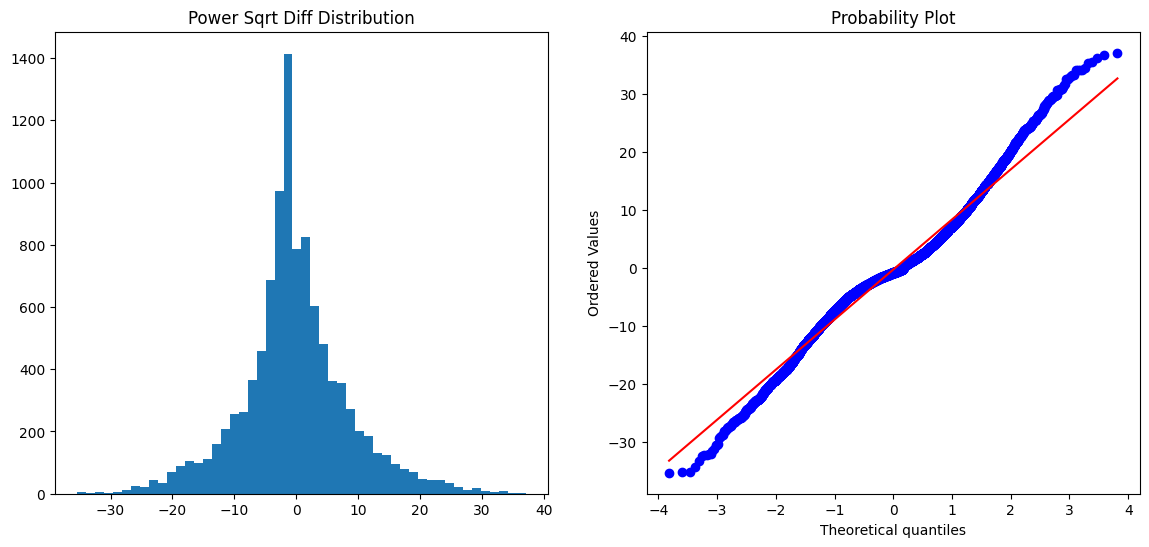

In [58]:
# 對差分後數據進行平方根變換（可以替換為 Box-Cox 或其他變換）
data['Power(mW)_sqrt_diff'] = np.sqrt(data['Power(mW)_diff'].abs()) * np.sign(data['Power(mW)_diff'])
data = data.dropna().reset_index(drop=True)

plt.figure(figsize=(14, 6))

# 左側繪製平方根變換後的直方圖
plt.subplot(1, 2, 1)
plt.hist(data['Power(mW)_sqrt_diff'], bins=50)
plt.title("Power Sqrt Diff Distribution")

# 右側繪製 QQ plot
plt.subplot(1, 2, 2)
stats.probplot(data['Power(mW)_sqrt_diff'], dist="norm", plot=plt)
plt.title("Probability Plot")

plt.show()

In [59]:
data = data.dropna().reset_index(drop=True)
data.to_csv('/home/s312657018/TBrain/data-preprocess/AvgDATA.csv')

---------------

# Test Data

##### Test data 終止提供觀測時間，從氣象局網站抓取東華站的其他特徵資料 (但很爛，後來用模擬的放在 testResult())

### Pressure(hpa),	Temperature(°C),	Humidity(%),	WindSpeed(m/s)

In [31]:
# # 讀取 XML 文件
# tree = ET.parse('/home/s312657018/Documents/TBrain/data-preprocess/C-B0024-002.xml') 
# root = tree.getroot()

# # 初始化空列表來存儲每個時間點的數據
# data = []

# # 定義命名空間（如果存在命名空間）
# ns = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}

# start_date = datetime.strptime("2024-01-01", "%Y-%m-%d")
# end_date = datetime.strptime("2024-07-24", "%Y-%m-%d")

# # 遍歷所有的 stationObsTime 節點，提取數據
# for station in root.findall('.//cwa:stationObsTime', ns):  # 無命名空間時可使用 './/stationObsTime'
#     # 提取日期和時間
#     data_time = station.find('cwa:DataTime', ns).text
#     date_str, time_str = data_time.split('T')  # 拆分出日期和時間部分
#     date_obj = datetime.strptime(date_str, "%Y-%m-%d")  # 將日期轉換為 datetime 對象以便比較
#     time_obj = datetime.strptime(time_str.split("+")[0], "%H:%M:%S").time()  # 時間部分轉換為 time 對象
    
#     # 只處理在指定日期範圍內的數據
#     if start_date <= date_obj <= end_date and datetime.strptime("07:00:00", "%H:%M:%S").time() <= time_obj <= datetime.strptime("16:00:00", "%H:%M:%S").time():
#         # 提取 weatherElements 中的幾個所需元素
#         weather_elements = station.find('cwa:weatherElements', ns)
        
#         def safe_float(value, default=0.0):
#             """安全轉換為 float，如果無法轉換則使用預設值"""
#             try:
#                 return float(value)
#             except (ValueError, TypeError):
#                 return default
        
#         # 只提取所需的幾個元素
#         air_pressure = safe_float(weather_elements.find('cwa:AirPressure', ns).text if weather_elements.find('cwa:AirPressure', ns) is not None else "0.0")
#         air_temperature = safe_float(weather_elements.find('cwa:AirTemperature', ns).text if weather_elements.find('cwa:AirTemperature', ns) is not None else "0.0")
#         relative_humidity = safe_float(weather_elements.find('cwa:RelativeHumidity', ns).text if weather_elements.find('cwa:RelativeHumidity', ns) is not None else "0.0")
#         wind_speed = safe_float(weather_elements.find('cwa:WindSpeed', ns).text if weather_elements.find('cwa:WindSpeed', ns) is not None else "0.0")

#         # 添加到數據列表
#         data.append({
#             "Date": date_str,
#             "DataTime": data_time,
#             'Pressure(hpa)': air_pressure,
#             'Temperature(°C)': air_temperature,
#             'Humidity(%)': relative_humidity,
#             'WindSpeed(m/s)': wind_speed
#         })

# # 將數據轉換為 DataFrame
# df = pd.DataFrame(data)
# df = df.iloc[:4943, :]
# df = df.fillna(method='ffill')
# df

In [ ]:
def transfer_series(original_df):
    hour_to_minite_df = []

    for _, row in original_df.iterrows():
        base_time = row['DataTime']
        if base_time.hour >= 9 and base_time.hour <= 16:
            for minute_offset in range(0, 60, 10):  # 每小時六筆資料（10 分鐘為一個間隔）
                new_time = base_time + timedelta(minutes=minute_offset)
                formatted_time = new_time.strftime('%Y%m%d%H%M') + '__'  # 格式化時間並附加 "01__"
                
                # 將原始數據複製並更新 DataTime
                new_row = row.copy()
                new_row['DataTime'] = formatted_time
                hour_to_minite_df.append(new_row)

    # 將列表轉換為 DataFrame
    hour_to_minite_df = pd.DataFrame(hour_to_minite_df)
    return hour_to_minite_df

In [ ]:
df['DataTime'] = pd.to_datetime(df['DataTime'])

climate_df = transfer_series(df)
climate_df.tail(12) 

,Date,DataTime,Pressure(hpa),Temperature(°C),Humidity(%),WindSpeed(m/s)
4935,2024-07-24,202407241500__,979.6,27.7,91.0,4.1
4935,2024-07-24,202407241510__,979.6,27.7,91.0,4.1
4935,2024-07-24,202407241520__,979.6,27.7,91.0,4.1
4935,2024-07-24,202407241530__,979.6,27.7,91.0,4.1
4935,2024-07-24,202407241540__,979.6,27.7,91.0,4.1
4935,2024-07-24,202407241550__,979.6,27.7,91.0,4.1
4936,2024-07-24,202407241600__,978.3,27.5,92.0,3.7
4936,2024-07-24,202407241610__,978.3,27.5,92.0,3.7
4936,2024-07-24,202407241620__,978.3,27.5,92.0,3.7
4936,2024-07-24,202407241630__,978.3,27.5,92.0,3.7


In [ ]:
solar = pd.read_excel('data-preprocess/SolarRadiation.xlsx', header=1)
solar['DataTime'] = pd.to_datetime(solar['DataTime'])

solar_df = transfer_series(solar)
solar_df.tail(12)

,序號,DataTime,SolarRadiation(MJ/m2)
4934,72S200,202407241500__,0.46
4934,72S200,202407241510__,0.46
4934,72S200,202407241520__,0.46
4934,72S200,202407241530__,0.46
4934,72S200,202407241540__,0.46
4934,72S200,202407241550__,0.46
4935,72S200,202407241600__,0.38
4935,72S200,202407241610__,0.38
4935,72S200,202407241620__,0.38
4935,72S200,202407241630__,0.38


In [ ]:
def convert_to_lux(solar_radiation_mj):
    # 1. 將 MJ/m² 轉為 W/m²，假設每筆數據表示每小時累積的輻射量
    power_density_w = (solar_radiation_mj * 1_000_000) / 3600  # 3600秒為1小時
    
    # 2. 轉換為 Lux，使用近似換算公式
    sunlight_lux = power_density_w * 10
    return sunlight_lux

# 應用轉換函數
solar_df['Sunlight(Lux)'] = solar_df['SolarRadiation(MJ/m2)'].apply(convert_to_lux)
solar_df = solar_df.fillna(method='ffill')
solar_df

,序號,DataTime,SolarRadiation(MJ/m2),Sunlight(Lux)
8,72S200,202401010900__,0.30,833.333333
8,72S200,202401010910__,0.30,833.333333
8,72S200,202401010920__,0.30,833.333333
8,72S200,202401010930__,0.30,833.333333
8,72S200,202401010940__,0.30,833.333333
...,...,...,...,...
4935,72S200,202407241610__,0.38,1055.555556
4935,72S200,202407241620__,0.38,1055.555556
4935,72S200,202407241630__,0.38,1055.555556
4935,72S200,202407241640__,0.38,1055.555556


In [ ]:
expanded_df = pd.merge(climate_df, solar_df,  on='DataTime', how='inner')
expanded_df

,Date,DataTime,Pressure(hpa),Temperature(°C),Humidity(%),WindSpeed(m/s),序號,SolarRadiation(MJ/m2),Sunlight(Lux)
0,2024-01-01,202401010900__,1022.2,16.9,68.0,2.6,72S200,0.30,833.333333
1,2024-01-01,202401010910__,1022.2,16.9,68.0,2.6,72S200,0.30,833.333333
2,2024-01-01,202401010920__,1022.2,16.9,68.0,2.6,72S200,0.30,833.333333
3,2024-01-01,202401010930__,1022.2,16.9,68.0,2.6,72S200,0.30,833.333333
4,2024-01-01,202401010940__,1022.2,16.9,68.0,2.6,72S200,0.30,833.333333
...,...,...,...,...,...,...,...,...,...
9883,2024-07-24,202407241610__,978.3,27.5,92.0,3.7,72S200,0.38,1055.555556
9884,2024-07-24,202407241620__,978.3,27.5,92.0,3.7,72S200,0.38,1055.555556
9885,2024-07-24,202407241630__,978.3,27.5,92.0,3.7,72S200,0.38,1055.555556
9886,2024-07-24,202407241640__,978.3,27.5,92.0,3.7,72S200,0.38,1055.555556


In [ ]:
test_data = pd.read_csv('/home/s312657018/Documents/TBrain/示範程式/LSTM(比賽用)/ExampleTestData/upload.csv')
test_data

,序號,答案
0,20240102090001,1277.55
1,20240102091001,1369.80
2,20240102092001,1462.67
3,20240102093001,1540.40
4,20240102094001,1594.30
...,...,...
9595,20240708161017,1.92
9596,20240708162017,2.98
9597,20240708163017,1.61
9598,20240708164017,1.93


In [ ]:
test_data['DataTime_trimmed'] = test_data['序號'].astype(str).str[:-2]
expanded_df['DataTime_trimmed'] = expanded_df['DataTime'].str[:-2]

merged_df = pd.merge(
    test_data,
    expanded_df,
    left_on='DataTime_trimmed',
    right_on='DataTime_trimmed',
    how='left',  # 根據需求選擇 inner 或其他合併方式
    suffixes=('_gen', '_orig')  # 可以用後綴區分來源
)

merged_df = merged_df.rename(columns={'序號_gen': 'Serial'})
columns = ['Serial', 'WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', '答案']
merged_df = merged_df[columns]

merged_df


,Serial,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),答案
0,20240102090001,1.1,1017.4,19.5,70.0,555.555556,1277.55
1,20240102091001,1.1,1017.4,19.5,70.0,555.555556,1369.80
2,20240102092001,1.1,1017.4,19.5,70.0,555.555556,1462.67
3,20240102093001,1.1,1017.4,19.5,70.0,555.555556,1540.40
4,20240102094001,1.1,1017.4,19.5,70.0,555.555556,1594.30
...,...,...,...,...,...,...,...
9595,20240708161017,4.2,1007.9,24.3,89.0,2444.444444,1.92
9596,20240708162017,4.2,1007.9,24.3,89.0,2444.444444,2.98
9597,20240708163017,4.2,1007.9,24.3,89.0,2444.444444,1.61
9598,20240708164017,4.2,1007.9,24.3,89.0,2444.444444,1.93
